In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.lib.stride_tricks import sliding_window_view

from sai.stats.scct_feature import *


import allel
import os

In [2]:

vcf_chr9 = os.path.join("examples", "data", "1KG.nea_den.chr9.example.vcf.gz")
ref_ind_file = os.path.join("examples", "data", "1KG.ref.samples.txt")
tgt_ind_file = os.path.join("examples", "data", "1KG.tgt.samples.txt")
src_ind_file = os.path.join("examples", "data", "1KG.src.samples.txt")


In [3]:
vcf_file_allel = allel.read_vcf(vcf_chr9)

In [4]:
genotypes = vcf_file_allel['calldata/GT']
genotype_array = allel.GenotypeArray(genotypes)


In [5]:
anc_allele_file = None
win_len = 50000
win_step = 50000
chr_name = "9"
vcf_file = vcf_chr9
ploidy = 2

In [6]:
is_phased = True

In [7]:
full_vcf = load_full_vcf(vcf_file, "9", ref_ind_file, tgt_ind_file, src_ind_file=src_ind_file, ploidy=2, is_phased=True)
full_vcf_tgt_gts = full_vcf[2]
full_vcf_positions = full_vcf[-1]

In [8]:
full_vcf_gts_filtered, full_indices_filtered = filter_zero_rows(full_vcf_tgt_gts, return_indices=True)

full_vcf_pos_filtered = np.delete(full_vcf_positions, full_indices_filtered, axis=0)

In [9]:
full_vcf_gts_filtered.shape

(3212, 1006)

In [10]:
snp_window_size = 71    
snp_slides = sliding_window_view(full_vcf_gts_filtered, window_shape=(snp_window_size, full_vcf_gts_filtered.shape[1]))
pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

In [11]:
theoretical_results = []
for i in range(len(snp_slides)):
    snp_window = snp_slides[i][0]
    pos_window = pos_slides[i]
    result = sample_scct_phased(snp_window, central_snp=None, theoretical=True, use_log_ratio=False, gts_pos=pos_window, full_vcf_gts=full_vcf_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=False)   
    theoretical_results.append(result)

theoretical ratio: 0.0807685898967384
theoretical ratio: 0.28054835214844503
theoretical ratio: 0.08547649736093296
theoretical ratio: 0.37581281074292844
theoretical ratio: 0.19701661670349432
theoretical ratio: 0.03256220730861434
theoretical ratio: 0.3742872666507676
theoretical ratio: 0.027148596912093956
theoretical ratio: 0.031949517337411894
theoretical ratio: 0.2168272470412527
theoretical ratio: 0.3742872666507676
theoretical ratio: 0.36973456977935376
theoretical ratio: 0.36521748871634335
theoretical ratio: 0.03133957053704637
theoretical ratio: 0.028331738250611943
theoretical ratio: 0.028331738250611943
theoretical ratio: 0.03133957053704637
theoretical ratio: 0.0634670471642731
theoretical ratio: 0.028927641910348786
theoretical ratio: 0.4610193521868302
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
theoretical ratio: 0.04206965207640195
theoretical ratio: 0.03379573741795502
theoretical ratio: 0.08706360094896577
th

In [12]:
theoretical_results

[nan,
 1.6840488314551083,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2.0487817065136458,
 -0.9867434715823722,
 nan,
 nan,
 nan,
 nan,
 2.570363191423123,
 1.847323771144581,
 nan,
 nan,
 1.6242553988201096,
 nan,
 nan,
 2.546736400871731,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.66028482918818,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2.106044796744988,
 1.680338926410998,
 nan,
 nan,
 nan,
 nan,
 3.0890597076151107,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2.1736249060996577,
 nan,
 2.1617671623106136,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2.203755005369993,
 2.228300527329107,
 nan,
 nan,
 nan,
 2.226955989311428,
 2.2030703083216756,
 -0.4941506533579374,
 2.1272393628134236,
 nan,
 nan,
 nan,
 1.7490495858975021,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2.3995531498940332,
 nan,
 2.489058216257143,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

In [13]:
len(theoretical_results)

3142

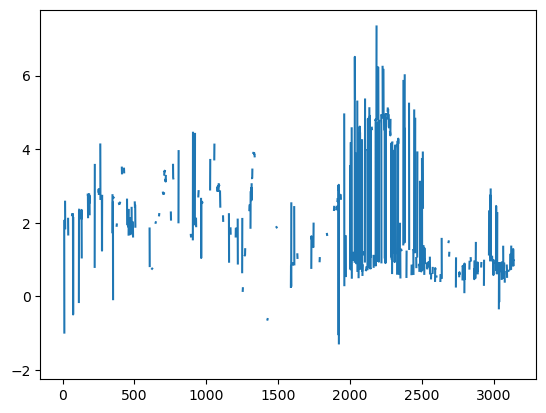

In [14]:
plt.plot(theoretical_results)

In [15]:
from scipy.ndimage import uniform_filter1d

def smooth_average(arr, window_size):
    arr = np.asarray(arr, dtype=float)
    
    # Replace inf with nan so all non-finite values are treated the same
    arr[~np.isfinite(arr)] = np.nan
    
    # Count finite values in each window
    counts = uniform_filter1d(np.isfinite(arr).astype(float), size=window_size, mode='nearest')
    
    # Replace nan with 0 for summing
    arr_no_nan = np.nan_to_num(arr, nan=0.0)
    
    # Compute sum in each window
    summed = uniform_filter1d(arr_no_nan, size=window_size, mode='nearest')
    
    # Avoid division by zero
    smoothed = summed / np.maximum(counts, 1)
    
    return smoothed

In [16]:
len(theoretical_results)

3142

In [17]:
smoothed_theoretical = smooth_average(theoretical_results, window_size=100)

In [18]:
len(smoothed_theoretical)

3142

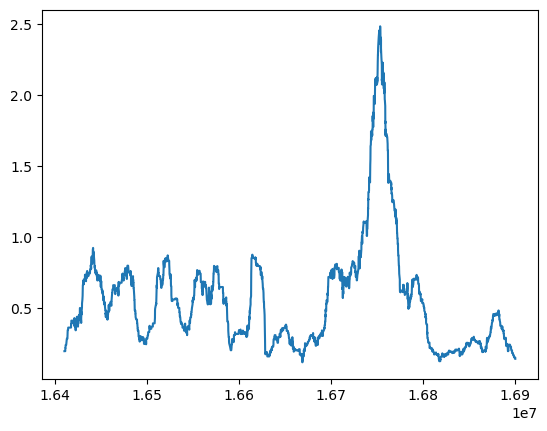

In [19]:
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_theoretical)

In [20]:
empirical_results = []
for i in range(len(snp_slides)):
    snp_window = snp_slides[i][0]
    pos_window = pos_slides[i]
    result = sample_scct_phased(snp_window, central_snp=None, theoretical=False, use_log_ratio=False, gts_pos=pos_window, full_vcf_gts=full_vcf_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=False)   
    empirical_results.append(result)

empirical ratio: 0.1745905756779334
empirical ratio: 0.599013456304808
empirical ratio: 0.15637098867470867
empirical ratio: 0.8104216514216985
empirical ratio: 0.42021912216866497
empirical ratio: 0.08055515847083809
empirical ratio: 0.8085680445035469
empirical ratio: 0.07013206326093112
empirical ratio: 0.07966475203281063
empirical ratio: 0.4615751328271278
empirical ratio: 0.8064053231062273
empirical ratio: 0.7971388268085214
empirical ratio: 0.7857779166332428
empirical ratio: 0.07852019822413596
empirical ratio: 0.07268691209860526
empirical ratio: 0.07268691209860526
empirical ratio: 0.07852019822413596
empirical ratio: 0.12668501639763194
empirical ratio: 0.07400434871961414
empirical ratio: 1.0022298813570556
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
empirical ratio: 0.10094830859824071
empirical ratio: 0.08373144492746945
empirical ratio: 0.14678690265870392
empirical ratio: 0.09172714752170347
empirical ratio: 0.0

In [21]:
empirical_results

[nan,
 0.913193317197279,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.2902437325679423,
 -1.5907333345925854,
 nan,
 nan,
 nan,
 nan,
 1.8018996975445876,
 1.0898355503957742,
 nan,
 nan,
 0.718465581511504,
 nan,
 nan,
 1.776495159212984,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7112301124860537,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.1923746407305054,
 0.924795024263108,
 nan,
 nan,
 nan,
 nan,
 2.32149680447705,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.4053814249914944,
 nan,
 1.3955859942440527,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.285280644944988,
 1.2861218543505155,
 nan,
 nan,
 nan,
 1.2847773163328366,
 1.2845959478966706,
 -1.1853336443086655,
 1.1879131103356007,
 nan,
 nan,
 nan,
 0.9725069288828452,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.5242711875786614,
 nan,
 1.5817783058447015,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

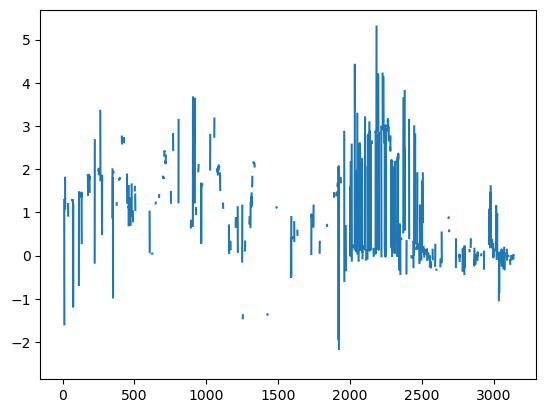

In [22]:
plt.plot(empirical_results)

In [23]:
smoothed_empirical = smooth_average(empirical_results, window_size=100)

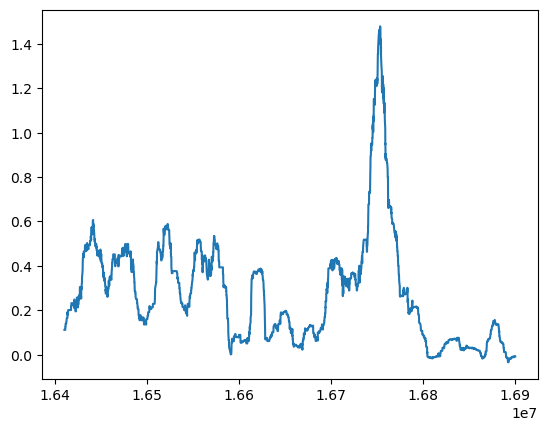

In [24]:
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_empirical)